In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
rootPath = '/content/gdrive/My Drive/3001_project'
import sys
sys.path.append('/content/gdrive/My Drive/3001_project')

import torch
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [99]:
class LR(nn.Module):
    def __init__(self, input_dim=2, output_dim=1):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        outputs = torch.sigmoid(outputs)
        return outputs

class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=1, dropout_rate=0):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        outputs = self.dropout(self.relu(self.linear1(x)))
        outputs = self.linear2(outputs)
        outputs = torch.sigmoid(outputs)
        return outputs

In [100]:
def weight_func(mode):
    if mode == 'up':
        return lambda y: y*9+1
    elif mode == 'down':
        return lambda y: abs(y-1)*9+1
    else:
        return lambda y: torch.ones(y.shape)

def train(model, criterion, optimizer, data, weight_func, device='cuda'):
    model.train()
    batch_loss = []
    # batch_loss = 0
    
    for X, y in data:
        X = X.to(device).float()
        y = y.to(device).float()
        
        outputs = model(X).to(device).float()
        criterion = nn.BCELoss(weight=weight_func(y).to(device).float())
        loss = criterion(outputs, y)
        # if y == 1.0:
        #     loss = loss * 10
        
        batch_loss.append(loss.detach().cpu().numpy())
        # batch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
    epoch_loss = np.mean(np.array(batch_loss))

    return epoch_loss

def evaluate(model, criterion, optimizer, data, device='cuda'):
    model.eval()
    batch_loss = []
    batch_acc = []
    batch_prediction = []
    
    for X, y in data:
        X = X.to(device).float()
        y = y.to(device).float()
        
        # loss
        outputs = model(X).to(device).float()
        loss = criterion(outputs, y)
        batch_loss.append(loss.detach().cpu().numpy())

        # accuracy
        y_pred = (outputs > 0.5) * 1.0
        y_pred = y_pred.detach().flatten().cpu().numpy()
        y = y.detach().flatten().cpu().numpy()
        batch_acc.extend(list(y_pred == y))

        # prediction
        batch_prediction.extend(list(y_pred))

    epoch_loss = np.mean(np.array(batch_loss))
    epoch_acc = np.mean(np.array(batch_acc))
    epoch_posi_percent = np.mean(np.array(batch_prediction))

    return epoch_loss, epoch_acc, epoch_posi_percent

## Truncated normal distribution

### Model Training

In [5]:
X_train = pickle.load(open(rootPath+'/features_1', 'rb')).T
y_train = pickle.load(open(rootPath+'/labels_1', 'rb')).T
X_test = pickle.load(open(rootPath+'/features_test', 'rb')).T
y_test = pickle.load(open(rootPath+'/labels_test', 'rb')).T

In [6]:
data_train, data_test = [], []
for i in range(len(y_train)):
    data_train.append((torch.tensor(X_train[i,:]), torch.tensor([y_train[i]])))
for i in range(len(y_test)):
    data_test.append((torch.tensor(X_test[i,:]), torch.tensor([y_test[i]])))

In [7]:
from torch.utils.data import Dataset

class TMLDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

from torch.utils.data import DataLoader

train_dataloader = DataLoader(TMLDataset(data_train), batch_size=8, shuffle=True)
test_dataloader = DataLoader(TMLDataset(data_test), batch_size=8, shuffle=False)

#### Without Regularization and Withoud Dropout

In [8]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:3.25, test loss:0.5099999904632568, test acc:0.74, test posi percent:0.7599999904632568
epoch:9, train loss:0.49000000953674316, test loss:0.17000000178813934, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.07999999821186066, test loss:0.019999999552965164, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.0, test loss:0.0, test acc:1.0, test posi percent:0.5


In [15]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.6200000047683716, test loss:0.5600000023841858, test acc:0.96, test posi percent:0.46000000834465027
epoch:9, train loss:0.30000001192092896, test loss:0.23000000417232513, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.05000000074505806, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.0, test loss:0.0, test acc:1.0, test posi percent:0.5


In [17]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:3.440000057220459, test loss:0.5299999713897705, test acc:0.53, test posi percent:0.029999999329447746
epoch:9, train loss:0.38999998569488525, test loss:0.15000000596046448, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.05999999865889549, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.0, test loss:0.0, test acc:1.0, test posi percent:0.5


In [20]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:3.700000047683716, test loss:0.6600000262260437, test acc:0.62, test posi percent:0.6499999761581421
epoch:9, train loss:1.1299999952316284, test loss:0.1899999976158142, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.18000000715255737, test loss:0.019999999552965164, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.029999999329447746, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


In [23]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.4300000071525574, test loss:0.3700000047683716, test acc:1.0, test posi percent:0.5
epoch:9, train loss:0.3400000035762787, test loss:0.2800000011920929, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.11999999731779099, test loss:0.07000000029802322, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.019999999552965164, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


In [35]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:4.079999923706055, test loss:0.9900000095367432, test acc:0.32, test posi percent:0.18000000715255737
epoch:9, train loss:1.159999966621399, test loss:0.28999999165534973, test acc:0.96, test posi percent:0.46000000834465027
epoch:99, train loss:0.18000000715255737, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.029999999329447746, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


#### With Regularization

In [49]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0.1
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:1.9900000095367432, test loss:0.4300000071525574, test acc:0.85, test posi percent:0.6399999856948853
epoch:9, train loss:0.8999999761581421, test loss:0.1899999976158142, test acc:0.98, test posi percent:0.5199999809265137
epoch:99, train loss:0.20000000298023224, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.10999999940395355, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.10999999940395355, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5


In [10]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0.1
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.20999999344348907, test loss:0.15000000596046448, test acc:1.0, test posi percent:0.5
epoch:9, train loss:0.1899999976158142, test loss:0.12999999523162842, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.10999999940395355, test loss:0.07000000029802322, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.05999999865889549, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.05999999865889549, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5


In [56]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0.1
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:6.059999942779541, test loss:1.4299999475479126, test acc:0.08, test posi percent:0.41999998688697815
epoch:9, train loss:1.3700000047683716, test loss:0.3400000035762787, test acc:0.91, test posi percent:0.4099999964237213
epoch:99, train loss:0.20999999344348907, test loss:0.03999999910593033, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.10999999940395355, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.10999999940395355, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5


In [39]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0.01
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:3.630000114440918, test loss:0.5799999833106995, test acc:0.58, test posi percent:0.9200000166893005
epoch:9, train loss:0.5299999713897705, test loss:0.18000000715255737, test acc:0.99, test posi percent:0.5099999904632568
epoch:99, train loss:0.07999999821186066, test loss:0.019999999552965164, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.019999999552965164, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


In [33]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0.01
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.6200000047683716, test loss:0.5600000023841858, test acc:0.99, test posi percent:0.5099999904632568
epoch:9, train loss:0.28999999165534973, test loss:0.2199999988079071, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.05999999865889549, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


In [35]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0.01
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:3.569999933242798, test loss:0.5899999737739563, test acc:0.51, test posi percent:0.009999999776482582
epoch:9, train loss:0.4099999964237213, test loss:0.14000000059604645, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.05999999865889549, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


#### With Dropout

In [12]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
dropout = 0.5
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(dropout_rate = dropout).to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_dropout{}_mode{}_reg{}_epoch{}.pt'.format(rootPath, dropout, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:2.509999990463257, test loss:0.7099999785423279, test acc:0.51, test posi percent:0.9900000095367432
epoch:9, train loss:0.4699999988079071, test loss:0.20000000298023224, test acc:0.99, test posi percent:0.5099999904632568
epoch:99, train loss:0.07999999821186066, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.019999999552965164, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.0, test loss:0.0, test acc:1.0, test posi percent:0.5


In [34]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
dropout = 0.5
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(dropout_rate = dropout).to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_dropout{}_mode{}_reg{}_epoch{}.pt'.format(rootPath, dropout, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.5299999713897705, test loss:0.46000000834465027, test acc:1.0, test posi percent:0.5
epoch:9, train loss:0.28999999165534973, test loss:0.20999999344348907, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.05999999865889549, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


In [56]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
dropout = 0.5
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(dropout_rate = dropout).to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model1/MLP_dropout{}_mode{}_reg{}_epoch{}.pt'.format(rootPath, dropout, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:4.610000133514404, test loss:0.6700000166893005, test acc:0.5, test posi percent:0.1599999964237213
epoch:9, train loss:0.5600000023841858, test loss:0.12999999523162842, test acc:1.0, test posi percent:0.5
epoch:99, train loss:0.07000000029802322, test loss:0.009999999776482582, test acc:1.0, test posi percent:0.5
epoch:999, train loss:0.019999999552965164, test loss:0.0, test acc:1.0, test posi percent:0.5
epoch:9999, train loss:0.009999999776482582, test loss:0.0, test acc:1.0, test posi percent:0.5


### Visualization

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

def plot_boundary(model_name_LR, model_name_MLP, plot_LR = True):
    # plot data points
    X, y = X_test, y_test
    clf = svm.SVC(kernel='linear', C=1000)
    clf.fit(X, y)
    color = plt.cm.tab10
    # color= 'Accent'
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=color)

    # plot the decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # ground truth decision boundary
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=1, linestyles=['--'])

    # decision boundary of MLP
    mlp = MLP().to(device)
    mlp.load_state_dict(torch.load('{}/model1/{}'.format(rootPath, model_name_MLP)))
    h = .02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = mlp(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
    Z = Z.reshape(xx.shape)
    Z = (Z > 0.5) * 1.0
    ax.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=color, alpha=0.2)

    if plot_LR:
      # decision boundary of LR
      # calculate the intercept and gradient of the decision boundary
      lr = LR().to(device)
      lr.load_state_dict(torch.load('{}/model1/{}'.format(rootPath, model_name_LR)))
      w1, w2, = lr.linear.weight.detach().cpu().flatten().numpy()
      b = lr.linear.bias.detach().cpu().numpy()
      c = -b/w2
      m = -w1/w2

      # xd = np.array([x_min, x_max])
      xd = np.arange(-6, 6, 0.00001)
      yd = m*xd + c
      keep = ((xd >= -6) & (xd <= 6)) & ((yd >= -6) & (yd <= 6))
      ax.plot(xd[keep], yd[keep], 'r', lw=1, ls='-')

    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')

    ax.set_aspect('equal', adjustable='box')
    plt.show()

#### Without Regularization

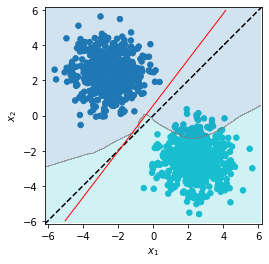

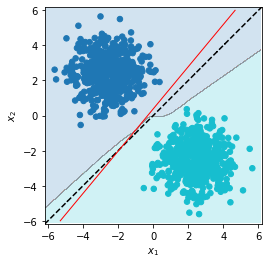

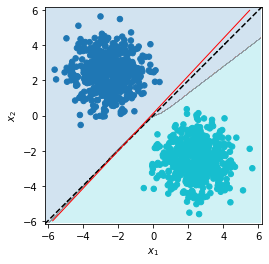

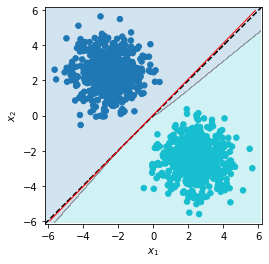

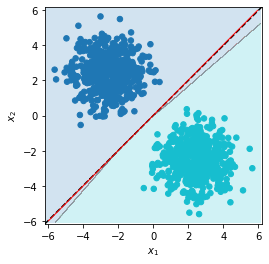

In [39]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

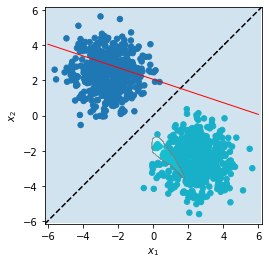

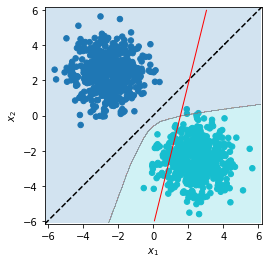

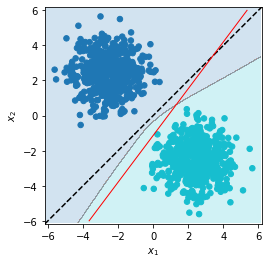

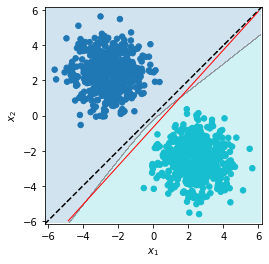

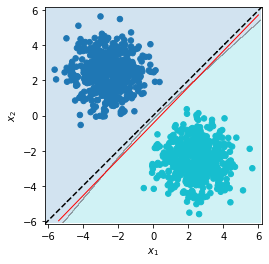

In [40]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format('down', 0, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format('down', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

#### With Dropout

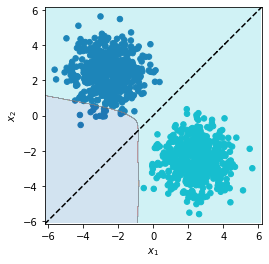

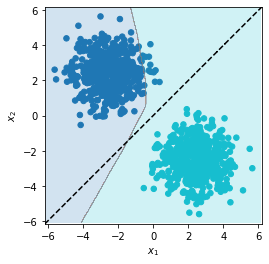

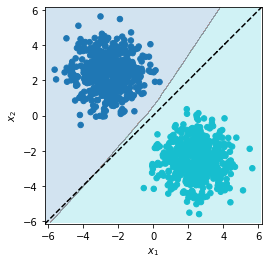

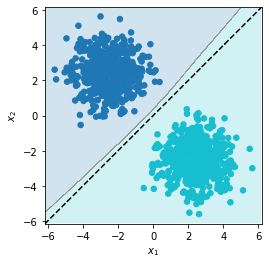

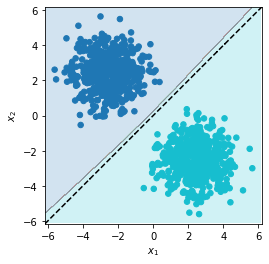

In [16]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_MLP = 'MLP_dropout{}_mode{}_reg{}_epoch{}.pt'.format(0.5, 'up', 0, epoch)
    model_name_LR = None
    plot_boundary(model_name_LR, model_name_MLP, plot_LR = False)

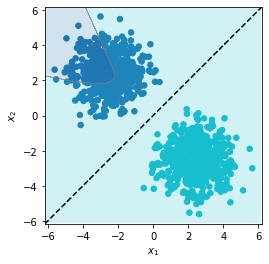

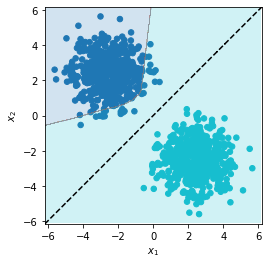

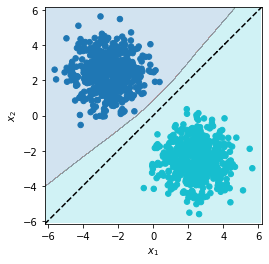

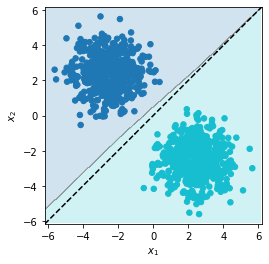

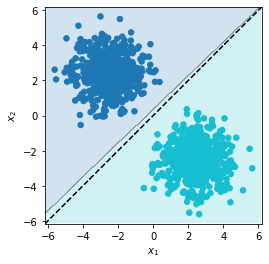

In [61]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_MLP = 'MLP_dropout{}_mode{}_reg{}_epoch{}.pt'.format(0.5, 'up', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP, plot_LR = False)

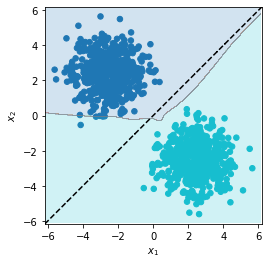

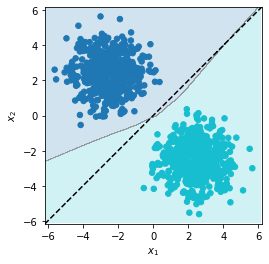

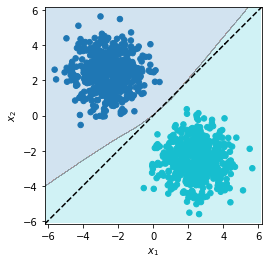

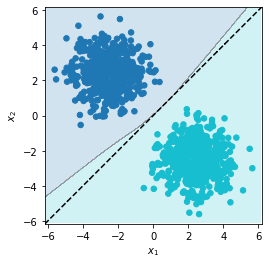

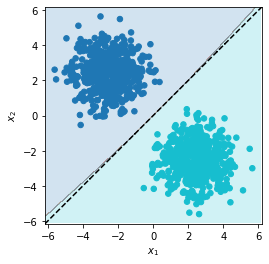

In [62]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_MLP = 'MLP_dropout{}_mode{}_reg{}_epoch{}.pt'.format(0.5, 'equal', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP, plot_LR = False)

#### With Regularization

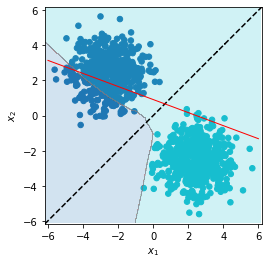

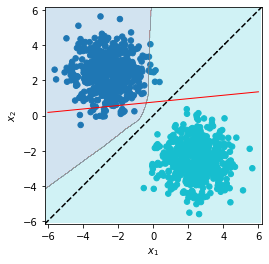

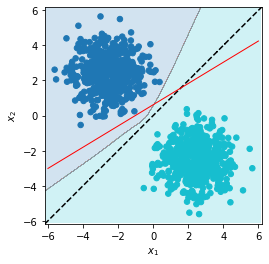

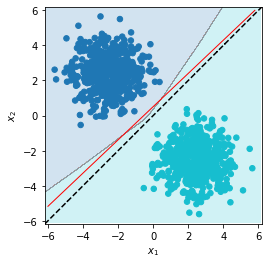

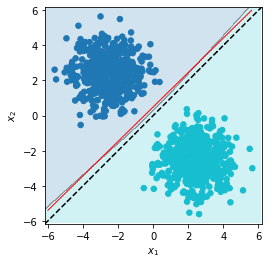

In [29]:
# plt.figure(figsize=(5, 20))
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format('up', reg, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format('up', 0.01, epoch)
    # plt.subplot(1, 5, i+1)
    plot_boundary(model_name_LR, model_name_MLP)

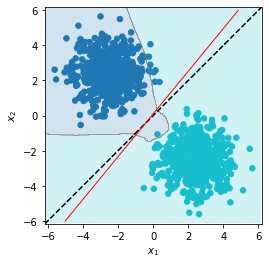

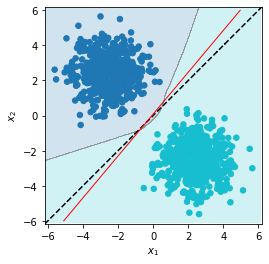

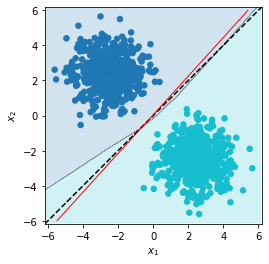

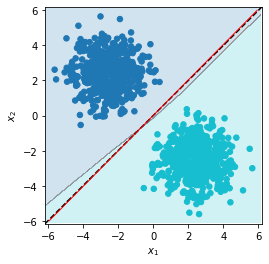

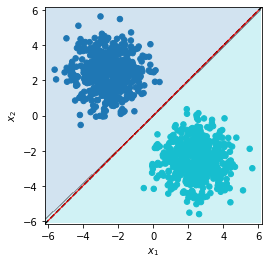

In [30]:
for epoch in [0, 9, 99, 999, 9999]:
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format("equal", reg, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format("equal", 0.01, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

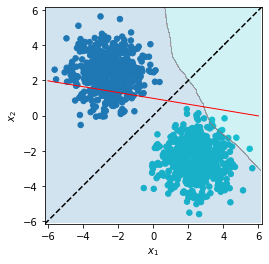

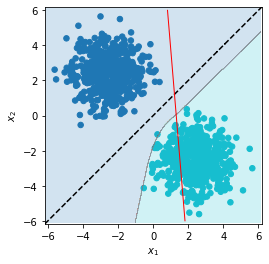

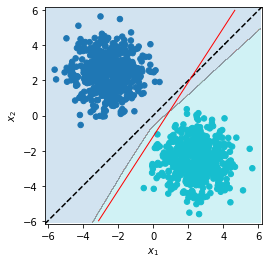

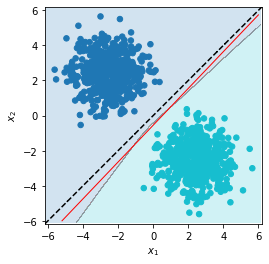

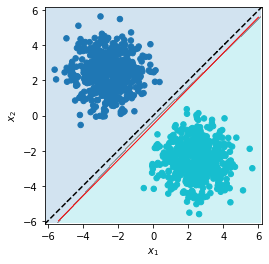

In [17]:
for epoch in [0, 9, 99, 999, 9999]:
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format("down", reg, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format("down", 0.01, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

## Moon Data

In [101]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [102]:
X, y = make_moons(n_samples=1024, noise=0.1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

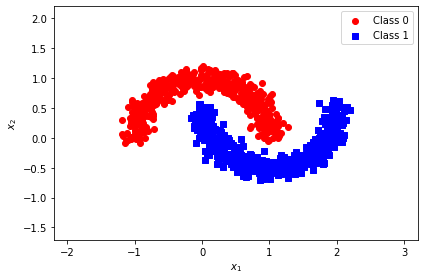

In [103]:
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            c='r', marker='o', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1],
            c='b', marker='s', label='Class 1')

plt.xlim(X[:, 0].min()-1, X[:, 0].max()+1)
plt.ylim(X[:, 1].min()-1, X[:, 1].max()+1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./output/fig-two-moon.png', dpi=300)
plt.show()

In [67]:
idx = np.random.choice(len(X_train[y_train==0]), size = round(len(X_train[y_train==0])/10))
X_train_pos = np.concatenate((X_train[y_train==0][idx], X_train[y_train==1]))
y_train_pos = np.concatenate((y_train[y_train==0][idx], y_train[y_train==1]))

idx = np.random.choice(len(X_train[y_train==1]), size = round(len(X_train[y_train==1])/10))
X_train_neg = np.concatenate((X_train[y_train==1][idx], X_train[y_train==0]))
y_train_neg = np.concatenate((y_train[y_train==1][idx], y_train[y_train==0]))

In [69]:
data_train_pos, data_train_neg, data_test = [], [], []
for i in range(len(y_train_pos)):
    data_train_pos.append((torch.tensor(X_train_pos[i,:]), torch.tensor([y_train_pos[i]])))
for i in range(len(y_train_neg)):
    data_train_neg.append((torch.tensor(X_train_neg[i,:]), torch.tensor([y_train_neg[i]])))
for i in range(len(y_test)):
    data_test.append((torch.tensor(X_test[i,:]), torch.tensor([y_test[i]])))

In [70]:
from torch.utils.data import Dataset

class TMLDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

from torch.utils.data import DataLoader
pos_train_moon_dataloader = DataLoader(TMLDataset(data_train_pos), batch_size=8, shuffle=True)
neg_train_moon_dataloader = DataLoader(TMLDataset(data_train_neg), batch_size=8, shuffle=True)
test_moon_dataloader = DataLoader(TMLDataset(data_test), batch_size=8, shuffle=False)

#### LR

In [21]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model2/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:4.429999828338623, test loss:0.6200000047683716, test acc:0.53, test posi percent:0.029999999329447746
epoch:9, train loss:2.4200000762939453, test loss:0.5199999809265137, test acc:0.73, test posi percent:0.6100000143051147
epoch:99, train loss:1.0499999523162842, test loss:0.6399999856948853, test acc:0.73, test posi percent:0.7799999713897705
epoch:999, train loss:0.6600000262260437, test loss:0.5, test acc:0.8, test posi percent:0.699999988079071
epoch:9999, train loss:0.5600000023841858, test loss:0.47999998927116394, test acc:0.83, test posi percent:0.6700000166893005


In [22]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model2/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.7200000286102295, test loss:0.7200000286102295, test acc:0.54, test posi percent:0.6800000071525574
epoch:9, train loss:0.6899999976158142, test loss:0.6899999976158142, test acc:0.56, test posi percent:0.699999988079071
epoch:99, train loss:0.5, test loss:0.5199999809265137, test acc:0.84, test posi percent:0.6100000143051147
epoch:999, train loss:0.27000001072883606, test loss:0.3199999928474426, test acc:0.84, test posi percent:0.5099999904632568
epoch:9999, train loss:0.20999999344348907, test loss:0.2800000011920929, test acc:0.86, test posi percent:0.5099999904632568


In [23]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model2/LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:3.450000047683716, test loss:0.5899999737739563, test acc:0.68, test posi percent:0.5600000023841858
epoch:9, train loss:2.2899999618530273, test loss:0.5699999928474426, test acc:0.77, test posi percent:0.27000001072883606
epoch:99, train loss:1.0099999904632568, test loss:0.6299999952316284, test acc:0.59, test posi percent:0.10000000149011612
epoch:999, train loss:0.6299999952316284, test loss:0.49000000953674316, test acc:0.81, test posi percent:0.3100000023841858
epoch:9999, train loss:0.550000011920929, test loss:0.46000000834465027, test acc:0.83, test posi percent:0.3499999940395355


#### MLP

In [16]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model2/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:3.7799999713897705, test loss:0.6200000047683716, test acc:0.73, test posi percent:0.7200000286102295
epoch:9, train loss:1.2300000190734863, test loss:0.7300000190734863, test acc:0.5, test posi percent:1.0
epoch:99, train loss:0.7400000095367432, test loss:0.5600000023841858, test acc:0.77, test posi percent:0.7300000190734863
epoch:999, train loss:0.3400000035762787, test loss:0.30000001192092896, test acc:0.9, test posi percent:0.6100000143051147
epoch:9999, train loss:0.019999999552965164, test loss:0.019999999552965164, test acc:0.99, test posi percent:0.5099999904632568


In [19]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model2/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:2.859999895095825, test loss:0.5799999833106995, test acc:0.73, test posi percent:0.23000000417232513
epoch:9, train loss:1.1100000143051147, test loss:0.7200000286102295, test acc:0.5, test posi percent:0.0
epoch:99, train loss:0.6499999761581421, test loss:0.5, test acc:0.8, test posi percent:0.3100000023841858
epoch:999, train loss:0.3700000047683716, test loss:0.3199999928474426, test acc:0.88, test posi percent:0.38999998569488525
epoch:9999, train loss:0.019999999552965164, test loss:0.019999999552965164, test acc:1.0, test posi percent:0.5


In [18]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model2/MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.7200000286102295, test loss:0.7099999785423279, test acc:0.51, test posi percent:0.9900000095367432
epoch:9, train loss:0.6200000047683716, test loss:0.6200000047683716, test acc:0.72, test posi percent:0.7699999809265137
epoch:99, train loss:0.3499999940395355, test loss:0.3799999952316284, test acc:0.83, test posi percent:0.5
epoch:999, train loss:0.18000000715255737, test loss:0.23000000417232513, test acc:0.88, test posi percent:0.5099999904632568
epoch:9999, train loss:0.019999999552965164, test loss:0.029999999329447746, test acc:1.0, test posi percent:0.5


#### Visualization

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

def plot_boundary(model_name_LR, model_name_MLP, plot_LR = True):
    # plot data points
    X, y = X_test, y_test

    color = plt.cm.tab10
    # color= 'Accent'
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=color)

    # plot the decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # decision boundary of MLP
    mlp = MLP().to(device)
    mlp.load_state_dict(torch.load('{}/model2/{}'.format(rootPath, model_name_MLP)))
    h = .02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = mlp(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
    Z = Z.reshape(xx.shape)
    Z = (Z > 0.5) * 1.0
    ax.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=color, alpha=0.2)

    if plot_LR:
      # decision boundary of LR
      # calculate the intercept and gradient of the decision boundary
      lr = LR().to(device)
      lr.load_state_dict(torch.load('{}/model2/{}'.format(rootPath, model_name_LR)))
      w1, w2, = lr.linear.weight.detach().cpu().flatten().numpy()
      b = lr.linear.bias.detach().cpu().numpy()
      c = -b/w2
      m = -w1/w2

      # xd = np.array([x_min, x_max])
      xd = np.arange(x_min, x_max, 0.00001)
      yd = m*xd + c
      keep = ((xd >= x_min) & (xd <= x_max)) & ((yd >= y_min) & (yd <= y_max))
      ax.plot(xd[keep], yd[keep], 'r', lw=1, ls='-')

    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')
    ax.set_aspect(1./ax.get_data_ratio())
    # ax.set_aspect('equal', adjustable='box')
    plt.show()

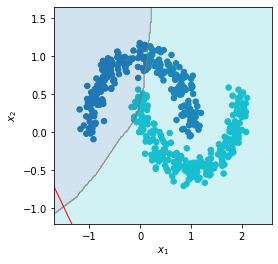

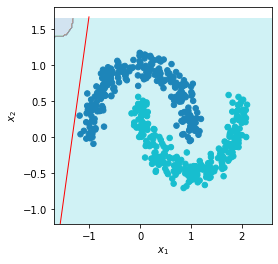

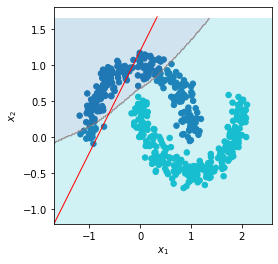

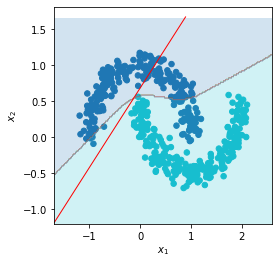

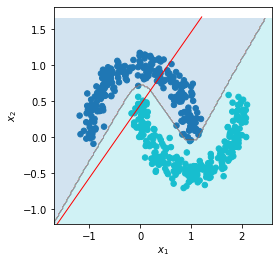

In [32]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format('up', 0, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format('up', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

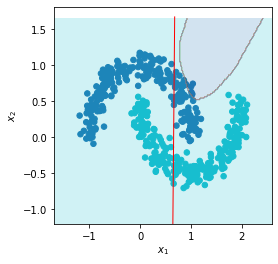

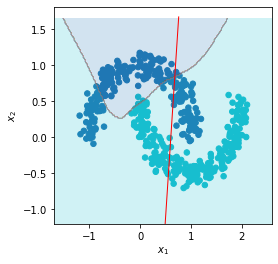

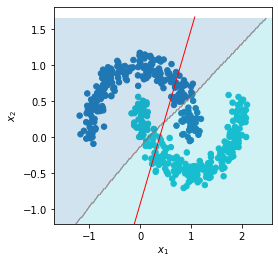

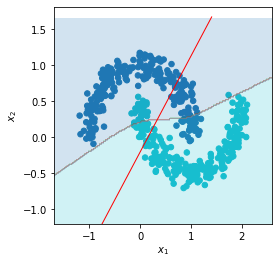

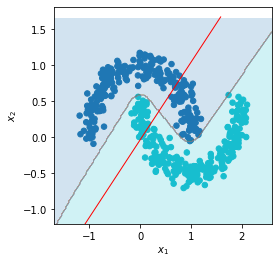

In [31]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

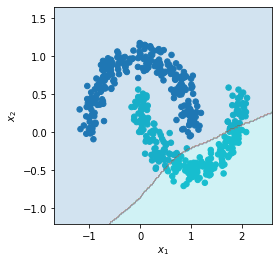

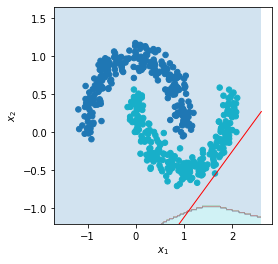

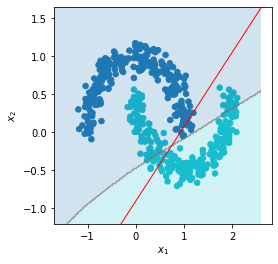

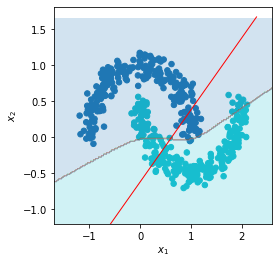

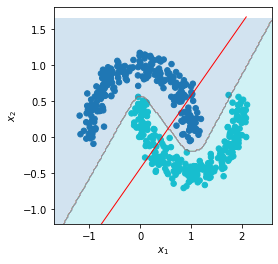

In [33]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'LR_mode{}_reg{}_epoch{}.pt'.format('down', 0, epoch)
    model_name_MLP = 'MLP_mode{}_reg{}_epoch{}.pt'.format('down', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

### Imbalanced

#### LR

In [104]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_pos)[1])) * 0.01
reg = 0
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, pos_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/pos_LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:1.25, test loss:0.6899999976158142, test acc:0.61, test posi percent:0.8999999761581421
epoch:9, train loss:1.2000000476837158, test loss:0.6600000262260437, test acc:0.64, test posi percent:0.8600000143051147
epoch:99, train loss:0.8999999761581421, test loss:0.5299999713897705, test acc:0.72, test posi percent:0.6100000143051147
epoch:999, train loss:0.5299999713897705, test loss:0.3400000035762787, test acc:0.83, test posi percent:0.5
epoch:9999, train loss:0.38999998569488525, test loss:0.2800000011920929, test acc:0.86, test posi percent:0.5099999904632568


In [105]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_pos)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, pos_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/pos_LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:1.0299999713897705, test loss:0.7699999809265137, test acc:0.5, test posi percent:0.0
epoch:9, train loss:0.9200000166893005, test loss:0.7200000286102295, test acc:0.5, test posi percent:0.0
epoch:99, train loss:0.4300000071525574, test loss:0.5600000023841858, test acc:0.79, test posi percent:0.7200000286102295
epoch:999, train loss:0.18000000715255737, test loss:0.6700000166893005, test acc:0.71, test posi percent:0.7900000214576721
epoch:9999, train loss:0.11999999731779099, test loss:0.5299999713897705, test acc:0.79, test posi percent:0.7099999785423279


In [106]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_neg)[1])) * 0.01
reg = 0
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, neg_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/neg_LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.9100000262260437, test loss:0.5199999809265137, test acc:0.8, test posi percent:0.7099999785423279
epoch:9, train loss:0.8799999952316284, test loss:0.5, test acc:0.81, test posi percent:0.6899999976158142
epoch:99, train loss:0.6700000166893005, test loss:0.4099999964237213, test acc:0.82, test posi percent:0.5400000214576721
epoch:999, train loss:0.4099999964237213, test loss:0.30000001192092896, test acc:0.85, test posi percent:0.5
epoch:9999, train loss:0.30000001192092896, test loss:0.30000001192092896, test acc:0.85, test posi percent:0.49000000953674316


In [107]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_neg)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LR().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, neg_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/neg_LR_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.38999998569488525, test loss:0.6700000166893005, test acc:0.5, test posi percent:0.0
epoch:9, train loss:0.3700000047683716, test loss:0.6700000166893005, test acc:0.5, test posi percent:0.0
epoch:99, train loss:0.27000001072883606, test loss:0.6800000071525574, test acc:0.5, test posi percent:0.0
epoch:999, train loss:0.15000000596046448, test loss:0.5799999833106995, test acc:0.7, test posi percent:0.20999999344348907
epoch:9999, train loss:0.10999999940395355, test loss:0.46000000834465027, test acc:0.82, test posi percent:0.33000001311302185


#### MLP

In [108]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_pos)[1])) * 0.01
reg = 0
mode = 'down'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, pos_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/pos_MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:1.3799999952316284, test loss:0.75, test acc:0.5, test posi percent:0.0
epoch:9, train loss:1.149999976158142, test loss:0.6399999856948853, test acc:0.68, test posi percent:0.5400000214576721
epoch:99, train loss:0.6200000047683716, test loss:0.38999998569488525, test acc:0.82, test posi percent:0.5199999809265137
epoch:999, train loss:0.36000001430511475, test loss:0.25999999046325684, test acc:0.87, test posi percent:0.5099999904632568
epoch:9999, train loss:0.05000000074505806, test loss:0.03999999910593033, test acc:0.99, test posi percent:0.5099999904632568


In [109]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_pos)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, pos_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/pos_MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.7699999809265137, test loss:0.7300000190734863, test acc:0.32, test posi percent:0.3700000047683716
epoch:9, train loss:0.550000011920929, test loss:0.7200000286102295, test acc:0.5, test posi percent:1.0
epoch:99, train loss:0.25999999046325684, test loss:0.8899999856948853, test acc:0.5, test posi percent:1.0
epoch:999, train loss:0.11999999731779099, test loss:0.5600000023841858, test acc:0.77, test posi percent:0.7400000095367432
epoch:9999, train loss:0.05999999865889549, test loss:0.3100000023841858, test acc:0.88, test posi percent:0.6200000047683716


In [110]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_pos)[1])) * 0.01
reg = 0
mode = 'up'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, neg_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/neg_MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:1.25, test loss:0.699999988079071, test acc:0.37, test posi percent:0.1899999976158142
epoch:9, train loss:1.1299999952316284, test loss:0.6200000047683716, test acc:0.76, test posi percent:0.5600000023841858
epoch:99, train loss:0.6000000238418579, test loss:0.3799999952316284, test acc:0.83, test posi percent:0.5
epoch:999, train loss:0.25999999046325684, test loss:0.25, test acc:0.87, test posi percent:0.49000000953674316
epoch:9999, train loss:0.029999999329447746, test loss:0.07999999821186066, test acc:0.97, test posi percent:0.47999998927116394


In [111]:
num_epoch = 10000
learning_rate = (1 / max(np.linalg.svd(X_train_pos)[1])) * 0.01
reg = 0
mode = 'equal'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg)

test_losses, test_accs, test_posi_percents = [], [], []
for epoch in range(num_epoch):
    calculate_weight = weight_func(mode)
    train_loss = train(model, criterion, optimizer, neg_train_moon_dataloader, calculate_weight, device=device)
    test_loss, test_acc, test_posi_percent = evaluate(model, criterion, optimizer, test_moon_dataloader, device=device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_posi_percents.append(test_posi_percent)

    # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(round(train_loss, 5), round(test_loss, 5), round(test_acc, 5), round(test_posi_percent, 5)))
    if epoch in [0, 9, 99, 999, 9999]:
        torch.save(model.state_dict(), '{}/model3/neg_MLP_mode{}_reg{}_epoch{}.pt'.format(rootPath, mode, reg, epoch))

        # print('train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(train_loss, test_loss, test_acc, test_posi_percent))
        print('epoch:{}, train loss:{}, test loss:{}, test acc:{}, test posi percent:{}'.format(epoch, round(train_loss, 2), round(test_loss, 2), round(test_acc, 2), round(test_posi_percent, 2)))

epoch:0, train loss:0.7699999809265137, test loss:0.6800000071525574, test acc:0.5, test posi percent:1.0
epoch:9, train loss:0.5, test loss:0.6600000262260437, test acc:0.5, test posi percent:0.0
epoch:99, train loss:0.2199999988079071, test loss:0.8399999737739563, test acc:0.5, test posi percent:0.0
epoch:999, train loss:0.11999999731779099, test loss:0.5, test acc:0.78, test posi percent:0.28999999165534973
epoch:9999, train loss:0.05000000074505806, test loss:0.3499999940395355, test acc:0.87, test posi percent:0.3799999952316284


#### Visualization

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

def plot_boundary(model_name_LR, model_name_MLP, plot_LR = True):
    # plot data points
    X, y = X_test, y_test
    # clf = svm.SVC(kernel='linear', C=1000)
    # clf.fit(X, y)
    color = plt.cm.tab10
    # color= 'Accent'
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=color)

    # plot the decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # decision boundary of MLP
    mlp = MLP().to(device)
    mlp.load_state_dict(torch.load('{}/model3/{}'.format(rootPath, model_name_MLP)))
    h = .02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = mlp(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
    Z = Z.reshape(xx.shape)
    Z = (Z > 0.5) * 1.0
    ax.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=color, alpha=0.2)

    if plot_LR:
      # decision boundary of LR
      # calculate the intercept and gradient of the decision boundary
      lr = LR().to(device)
      lr.load_state_dict(torch.load('{}/model3/{}'.format(rootPath, model_name_LR)))
      w1, w2, = lr.linear.weight.detach().cpu().flatten().numpy()
      b = lr.linear.bias.detach().cpu().numpy()
      c = -b/w2
      m = -w1/w2

      # xd = np.array([x_min, x_max])
      xd = np.arange(x_min, x_max, 0.00001)
      yd = m*xd + c
      keep = ((xd >= x_min) & (xd <= x_max)) & ((yd >= y_min) & (yd <= y_max))
      ax.plot(xd[keep], yd[keep], 'r', lw=1, ls='-')

    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')
    ax.set_aspect(1./ax.get_data_ratio())
    plt.show()

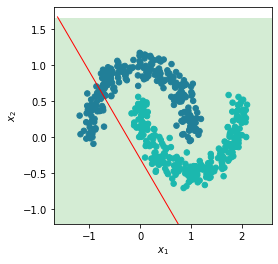

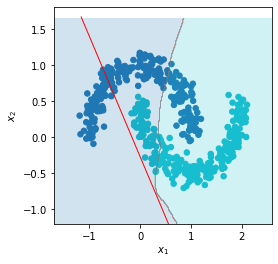

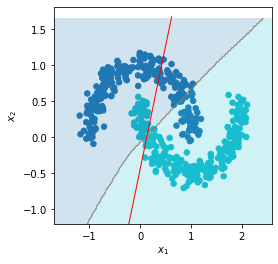

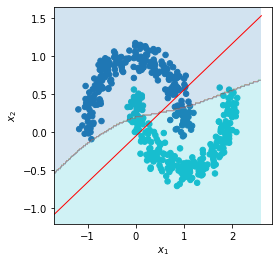

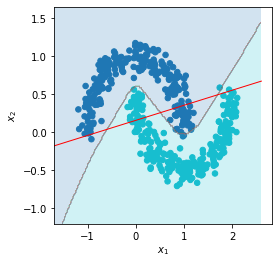

In [113]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'pos_LR_mode{}_reg{}_epoch{}.pt'.format('down', 0, epoch)
    model_name_MLP = 'pos_MLP_mode{}_reg{}_epoch{}.pt'.format('down', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

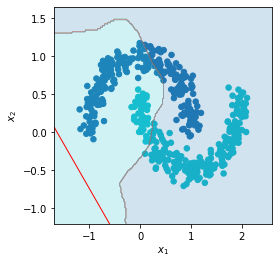

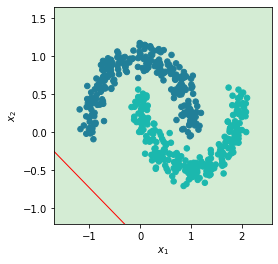

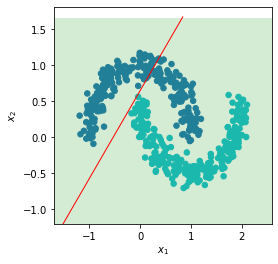

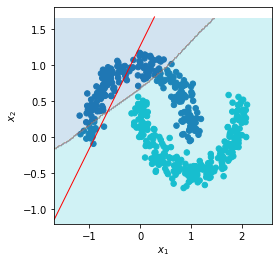

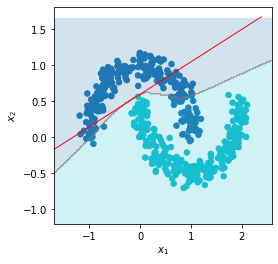

In [114]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'pos_LR_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    model_name_MLP = 'pos_MLP_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

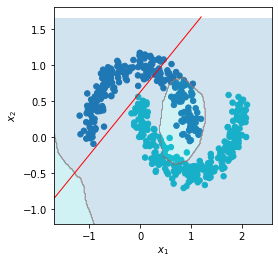

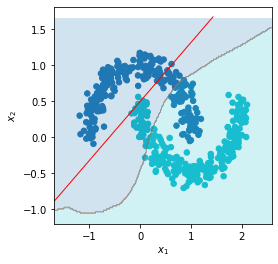

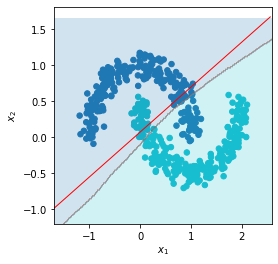

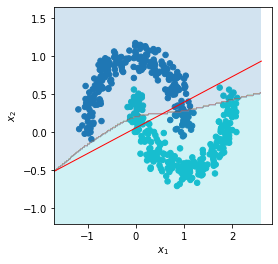

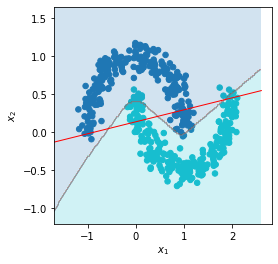

In [115]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'neg_LR_mode{}_reg{}_epoch{}.pt'.format('up', 0, epoch)
    model_name_MLP = 'neg_MLP_mode{}_reg{}_epoch{}.pt'.format('up', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)

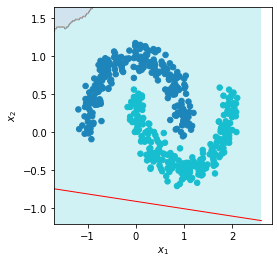

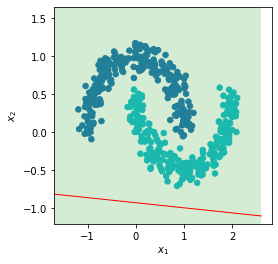

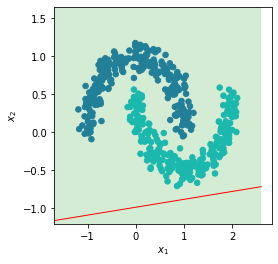

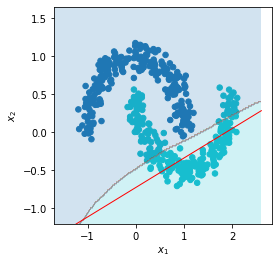

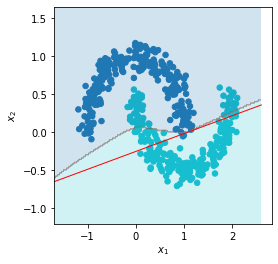

In [116]:
for i, epoch in enumerate([0, 9, 99, 999, 9999]):
    model_name_LR = 'neg_LR_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    model_name_MLP = 'neg_MLP_mode{}_reg{}_epoch{}.pt'.format('equal', 0, epoch)
    plot_boundary(model_name_LR, model_name_MLP)